In [161]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uncertainties as unc
import uncertainties.unumpy as unp

In [162]:
def linear_fit(x, a, b):
    return a*x + b

def inverseLinearFit(y, a, b):
    return (y-b)/a

1.504+/-0.006


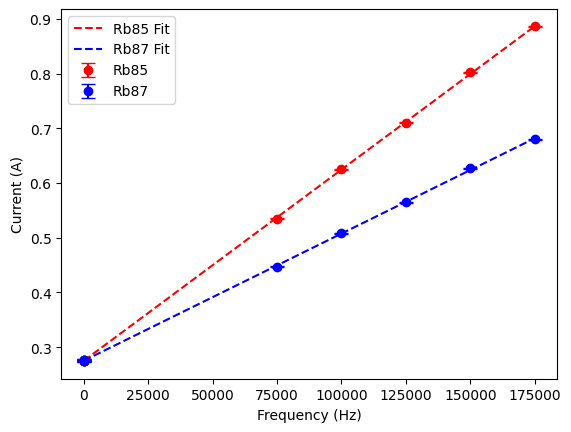

In [163]:
frequencies = np.array([0,0,0,0,0,75e3, 100e3, 125e3, 150e3, 175e3])
#uncs here should be 0.001
rb87 = np.array([0.274,0.275,0.276,0.277,0.275,0.447,0.508,0.565,0.627,0.680])
rb85 = np.array([0.274,0.275,0.276,0.277,0.275,0.535,0.625,0.710,0.802,0.886])
popt1, pcov1 = curve_fit(linear_fit, frequencies, rb85, sigma = 0.001*np.ones(len(frequencies)))
popt2, pcov2 = curve_fit(linear_fit, frequencies, rb87, sigma = 0.001*np.ones(len(frequencies)))
slope1 = unc.ufloat(popt1[0], np.sqrt(pcov1[0,0]))
slope2 = unc.ufloat(popt2[0], np.sqrt(pcov2[0,0]))
slope1 = 1/slope1
slope2 = 1/slope2
print(slope2/slope1)



plt.errorbar(frequencies, rb85, fmt = 'ro', yerr= 0.001, label='Rb85', capsize = 5)
plt.errorbar(frequencies, rb87, fmt = 'bo', yerr= 0.001, label='Rb87', capsize=5)
plt.plot(frequencies, linear_fit(frequencies, *popt1), 'r--', label='Rb85 Fit')
plt.plot(frequencies, linear_fit(frequencies, *popt2), 'b--', label='Rb87 Fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Current (A)')

plt.legend()


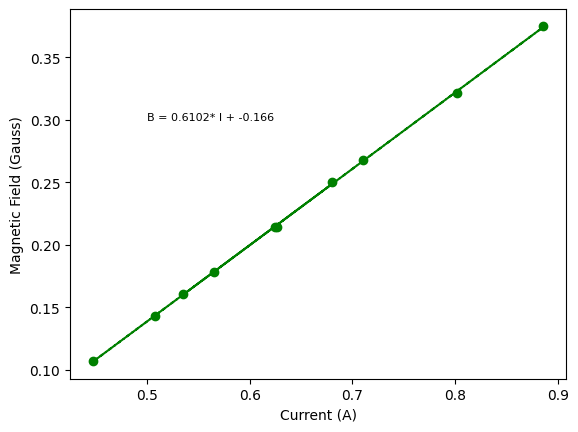

In [164]:
rb85Transitions = rb85[5:]
rb87Transitions = rb87[5:]
transitionFreqs = frequencies[5:]
B85 = transitionFreqs/1.3996e6*3
B87 = transitionFreqs/1.3996e6*2
BS = np.concatenate((B85, B87))
Is = np.concatenate((rb85Transitions, rb87Transitions))
Is = unp.uarray(Is, 0.001*np.ones(len(Is)))
popt3, pcov3 = curve_fit(inverseLinearFit, BS, unp.nominal_values(Is), sigma = unp.std_devs(Is))
plt.plot(unp.nominal_values(Is), unp.nominal_values(linear_fit(Is, *popt3)), 'g--', label='Fit')
plt.plot(unp.nominal_values(Is), unp.nominal_values(BS), 'go', label='Data')
plt.text(0.5, 0.3, 'B = ' + str(popt3[0])[:6] + '* I + ' + str(popt3[1])[:6], fontsize=8)
plt.xlabel('Current (A)')
plt.ylabel('Magnetic Field (Gauss)')
plt.show()

def sweepB(I):
    return unc.ufloat(popt3[0], np.sqrt(pcov3[0,0]))*I + unc.ufloat(popt3[1], np.sqrt(pcov3[1,1]))



[8.65617253] 0.04495507165684655


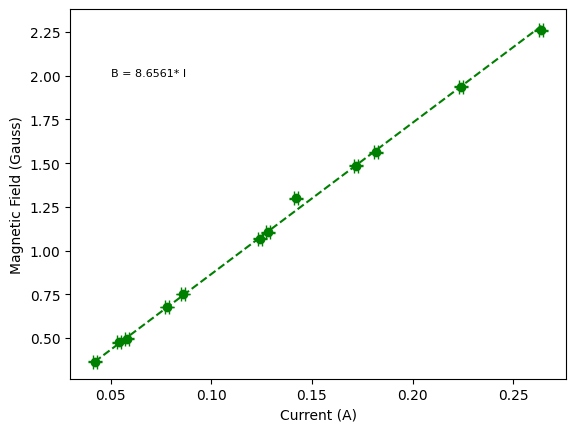

In [165]:
def slopeFit(x, a):
    return a*x
frequencies = np.array([1e6, 850e3, 650e3, 450e3, 250e3, 150e3])
zeroFieldSweep = np.array([0.019, 0.065, 0.021, 0.029,0.040, 0.019])
zeroFieldMain = np.array([0.008, 0.007, 0.008, 0.008, 0.008, 0.009])*2
firstPeakSweep = np.array([0.054, 0.135,0.043, 0.094, 0.044, 0.026 ])
firstPeakMain = np.array([0.091, 0.071, 0.062, 0.043, 0.029, 0.021])*2
secondPeakSweep = np.array([0.081, 0.083, 0.121, 0.042, 0.040, 0.020])
secondPeakMain = np.array([0.132, 0.112, 0.086, 0.064, 0.039, 0.027])*2
B85MainCal = frequencies/1.3996e6*3
B87MainCal = frequencies/1.3996e6*2
firstPeakMainB = B87MainCal - sweepB(firstPeakSweep)
secondPeakMainB = B85MainCal - sweepB(secondPeakSweep)
mainFieldBs = np.concatenate((firstPeakMainB, secondPeakMainB))
mainFieldIs = np.concatenate((firstPeakMain, secondPeakMain))
mainFieldIs = unp.uarray(mainFieldIs, 0.001*np.ones(len(mainFieldIs)))
sortedIs = unp.nominal_values(np.sort(mainFieldIs))
popt4, pcov4 = curve_fit(slopeFit, unp.nominal_values(mainFieldIs), unp.nominal_values(mainFieldBs), sigma = unp.std_devs(mainFieldBs))
print(popt4, np.sqrt(pcov4[0,0]))
plt.plot(sortedIs, slopeFit(sortedIs, *popt4), 'g--', label='Fit')
plt.errorbar(unp.nominal_values(mainFieldIs), unp.nominal_values(mainFieldBs),xerr = unp.std_devs(mainFieldIs), yerr = unp.std_devs(mainFieldBs), fmt = 'go', label='Data',capsize=5)
plt.text(0.05, 2, 'B = ' + str(popt4[0])[:6] + '* I', fontsize=8)
plt.xlabel('Current (A)')
plt.ylabel('Magnetic Field (Gauss)')
plt.show()

def BField(mainCoilCurrent, sweepCoilCurrent):
    return sweepB(sweepCoilCurrent) + unc.ufloat(popt4[0], np.sqrt(pcov4[0,0]))*mainCoilCurrent


In [166]:
fiveMegVoltage = 2.5e6/1.3996e6*3/popt4[0]/2
print(fiveMegVoltage)

0.3095290607536128


In [167]:
#omega I +1/2 solution
def quadraticResField(omega, g_f, muIScaler):
    J = 1/2
    I =3/2
    F = 2
    out = []
    for mBar in [-2.5, 1.5]:
        mu_N = 5.0507837393e-31
        mu_I= muIScaler*mu_N
        g_j =g_f*(2*F*(F+1))/(F*(F+1) - I*(I+1) + J*(J+1))
        mu_b = 9.274e-28
        hbar = 1.0545718e-34
        a = -2*mBar*((g_j*mu_b + mu_I/I)**2)/(((2*I + 1)**2)*hbar**2*6834.7e6*2*np.pi)
        b = (g_j*mu_b - 2*mu_I)/((2*I + 1)*hbar)
        c = -omega
        b2 = (g_j*mu_b - 2*mu_I*(1+1/I))/((2*I + 1)*hbar)
        out.append((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
        out.append((-b2 + np.sqrt(b2**2 - 4*a*c))/(2*a))
    return np.array(out)

print(quadraticResField(6.5e6*2*np.pi, 1/2, 2.75))


[9.25815618 9.2673359  9.32894717 9.33833916]


9.38+/-0.05 9.40+/-0.05 9.42+/-0.05 9.44+/-0.05
9.258162713613775 9.267346819112733 9.328953888303792 9.33835036561849


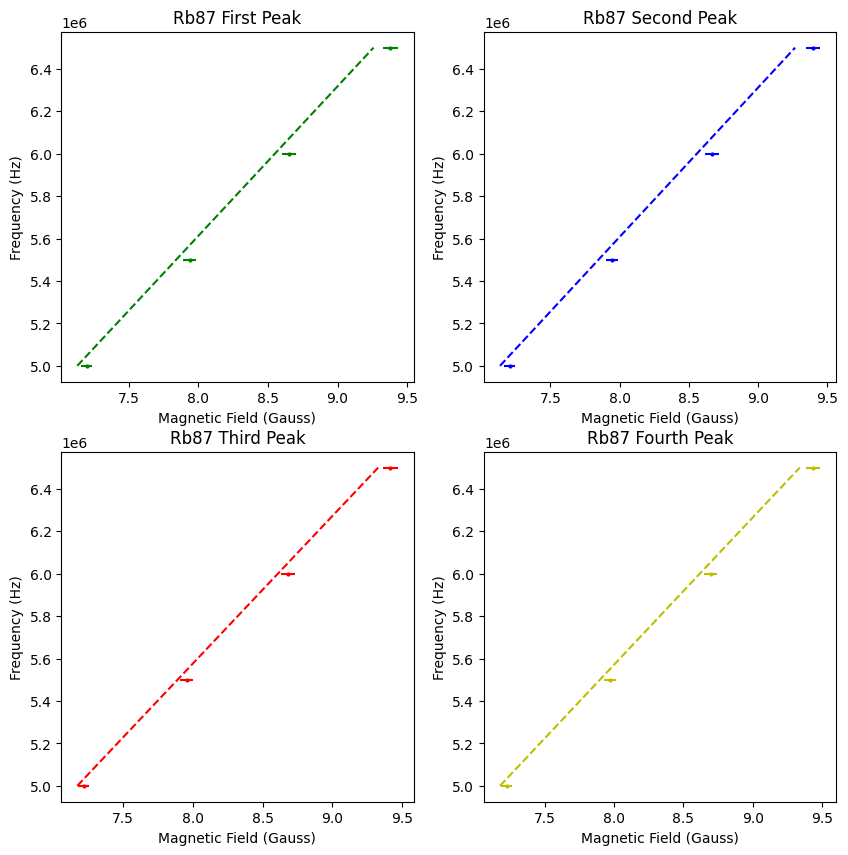

In [168]:
frequencies = np.array([5e6, 5.5e6, 6e6, 6.5e6])
mainCoilCurrents = np.array([0.410, 0.454, 0.495, 0.533])*2
mainCoilCurrents = unp.uarray(mainCoilCurrents, 0.002*np.ones(len(mainCoilCurrents)))
firstPeaks = np.array([0.433, 0.398, 0.407, 0.522])
firstPeaks = unp.uarray(firstPeaks, 0.001*np.ones(len(firstPeaks)))
secondPeaks = np.array([0.45, 0.409, 0.432, 0.552])
secondPeaks = unp.uarray(secondPeaks, 0.001*np.ones(len(secondPeaks)))
thridPeaks = np.array([0.468, 0.430, 0.457, 0.583])
thridPeaks = unp.uarray(thridPeaks, 0.001*np.ones(len(thridPeaks)))
fourthPeaks = np.array([0.485, 0.451, 0.481, 0.613])
fourthPeaks = unp.uarray(fourthPeaks, 0.001*np.ones(len(fourthPeaks)))
firstPeakBs = BField(mainCoilCurrents, firstPeaks)

secondPeakBs = BField(mainCoilCurrents, secondPeaks)
thirdPeakBs = BField(mainCoilCurrents, thridPeaks)
fourthPeakBs = BField(mainCoilCurrents, fourthPeaks)
predictedFirstPeaks = []
predictedSecondPeaks = []
predictedThirdPeaks = []
predictedFourthPeaks = []
plotFreqs = np.linspace(5e6, 6.5e6, 100)
for freq in plotFreqs:
    resonances = quadraticResField(freq*2*np.pi, 1/2, 2.75131)
    predictedFirstPeaks.append(resonances[0])
    predictedSecondPeaks.append(resonances[1])
    predictedThirdPeaks.append(resonances[2])
    predictedFourthPeaks.append(resonances[3])

print(firstPeakBs[3], secondPeakBs[3], thirdPeakBs[3], fourthPeakBs[3])
print(predictedFirstPeaks[-1], predictedSecondPeaks[-1], predictedThirdPeaks[-1], predictedFourthPeaks[-1])
#make a 2by 2 subplot
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].set_title("Rb87 First Peak")
ax[0,0].errorbar(unp.nominal_values(firstPeakBs), frequencies, xerr = unp.std_devs(firstPeakBs), fmt ="go", label='FirstPeak', markersize=2)
ax[0,0].plot(predictedFirstPeaks, plotFreqs, "g--", label='FirstPeakPredicted', markersize=2)
ax[0,0].set_xlabel('Magnetic Field (Gauss)')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[0,1].set_title("Rb87 Second Peak")
ax[0,1].errorbar(unp.nominal_values(secondPeakBs), frequencies, xerr = unp.std_devs(secondPeakBs), fmt ="bo", label='SecondPeak', markersize=2)
ax[0,1].plot(predictedSecondPeaks, plotFreqs, "b--", label='SecondPeakPredicted', markersize=2)
ax[0,1].set_xlabel('Magnetic Field (Gauss)')
ax[0,1].set_ylabel('Frequency (Hz)')
ax[1,0].set_title("Rb87 Third Peak")
ax[1,0].errorbar(unp.nominal_values(thirdPeakBs), frequencies, xerr = unp.std_devs(thirdPeakBs), fmt ="ro", label='ThirdPeak', markersize=2)
ax[1,0].plot(predictedThirdPeaks, plotFreqs, "r--", label='ThirdPeakPredicted', markersize=2)
ax[1,0].set_xlabel('Magnetic Field (Gauss)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,1].set_title("Rb87 Fourth Peak")
ax[1,1].errorbar(unp.nominal_values(fourthPeakBs), frequencies, xerr = unp.std_devs(fourthPeakBs), fmt ="yo", label='FourthPeak', markersize=2)
ax[1,1].plot(predictedFourthPeaks, plotFreqs, "y--", label='FourthPeakPredicted', markersize=2)
ax[1,1].set_xlabel('Magnetic Field (Gauss)')
ax[1,1].set_ylabel('Frequency (Hz)')
plt.show()


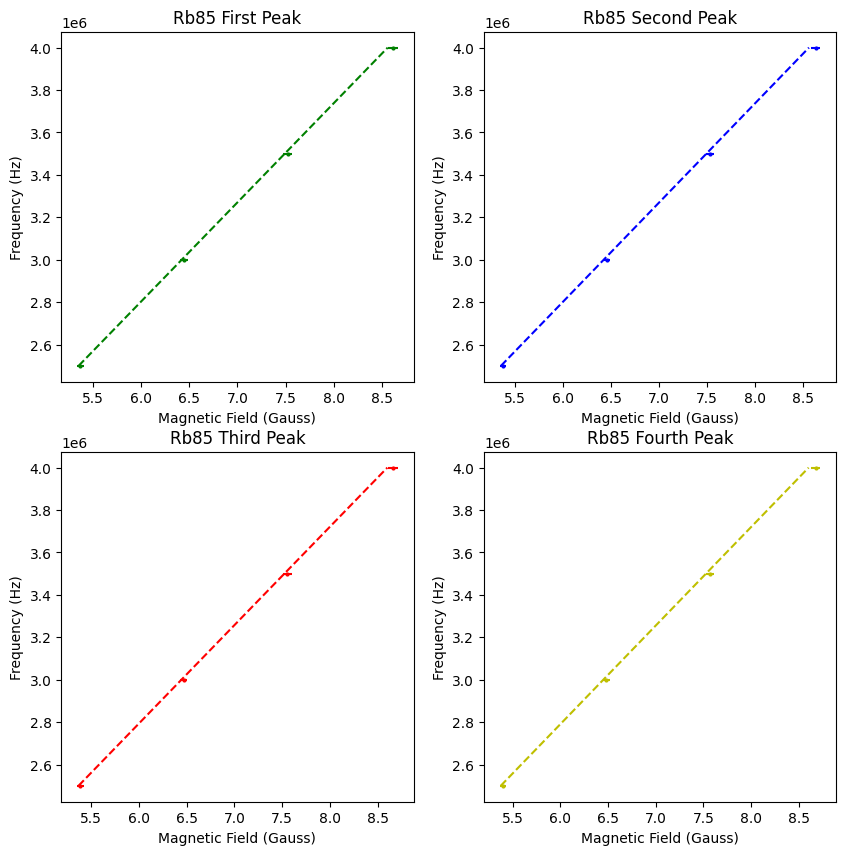

In [169]:
frequencies = np.array([2.5e6, 3e6, 3.5e6, 4e6])
mainFieldIs = np.array([0.310, 0.371, 0.433, 0.495])*2
mainFieldIs = unp.uarray(mainFieldIs, 0.002*np.ones(len(mainFieldIs)))
firstPeakIs = np.array([0.284, 0.310, 0.312, 0.343])
firstPeakIs = unp.uarray(firstPeakIs, 0.001*np.ones(len(firstPeakIs)))
secondPeakIs = np.array([0.297, 0.330, 0.340, 0.379])
secondPeakIs = unp.uarray(secondPeakIs, 0.001*np.ones(len(secondPeakIs)))
thirdPeakIs = np.array([0.312, 0.352, 0.368, 0.416])
thirdPeakIs = unp.uarray(thirdPeakIs, 0.001*np.ones(len(thirdPeakIs)))
fourthPeakIs = np.array([0.327, 0.372, 0.396, 0.452])
fourthPeakIs = unp.uarray(fourthPeakIs, 0.001*np.ones(len(fourthPeakIs)))
fifthPeakIs = np.array([0.341, 0.393, 0.425, 0.490])
sixthPeakIs = np.array([0.356, 0.414, 0.454, 0.527])
firstPeakBs = BField(mainFieldIs, firstPeakIs)
secondPeakBs = BField(mainFieldIs, secondPeakIs)
thirdPeakBs = BField(mainFieldIs, thirdPeakIs)
fourthPeakBs = BField(mainFieldIs, fourthPeakIs)
fifthPeakBs = BField(mainFieldIs, fifthPeakIs)
sixthPeakBs = BField(mainFieldIs, sixthPeakIs)
plotFreqs = np.linspace(2.5e6, 4e6, 100)
predictedFirstPeaks = []
predictedSecondPeaks = []
predictedThirdPeaks = []
predictedFourthPeaks = []
for freq in plotFreqs:
    resonances = quadraticResField(freq*2*np.pi, 1/3, 1.35298)
    predictedFirstPeaks.append(resonances[0])
    predictedSecondPeaks.append(resonances[1])
    predictedThirdPeaks.append(resonances[2])
    predictedFourthPeaks.append(resonances[3])

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].set_title('Rb85 First Peak')
ax[0,0].errorbar(unp.nominal_values(firstPeakBs), frequencies, xerr = unp.std_devs(firstPeakBs), fmt ="go", label='FirstPeak', markersize=2)
ax[0,0].plot(predictedFirstPeaks, plotFreqs, "g--", label='FirstPeakPredicted', markersize=2)
ax[0,0].set_xlabel('Magnetic Field (Gauss)')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[0,1].set_title('Rb85 Second Peak')
ax[0,1].errorbar(unp.nominal_values(secondPeakBs), frequencies, xerr = unp.std_devs(secondPeakBs), fmt ="bo", label='SecondPeak', markersize=2)
ax[0,1].plot(predictedSecondPeaks, plotFreqs, "b--", label='SecondPeakPredicted', markersize=2)
ax[0,1].set_xlabel('Magnetic Field (Gauss)')
ax[0,1].set_ylabel('Frequency (Hz)')
ax[1,0].set_title('Rb85 Third Peak')
ax[1,0].errorbar(unp.nominal_values(thirdPeakBs), frequencies, xerr = unp.std_devs(thirdPeakBs), fmt ="ro", label='ThirdPeak', markersize=2)
ax[1,0].plot(predictedThirdPeaks, plotFreqs, "r--", label='ThirdPeakPredicted', markersize=2)
ax[1,0].set_xlabel('Magnetic Field (Gauss)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,1].set_title('Rb85 Fourth Peak')
ax[1,1].errorbar(unp.nominal_values(fourthPeakBs), frequencies, xerr = unp.std_devs(fourthPeakBs), fmt ="yo", label='FourthPeak', markersize=2)
ax[1,1].plot(predictedFourthPeaks, plotFreqs, "y--", label='FourthPeakPredicted', markersize=2)
ax[1,1].set_xlabel('Magnetic Field (Gauss)')
ax[1,1].set_ylabel('Frequency (Hz)')
plt.show()


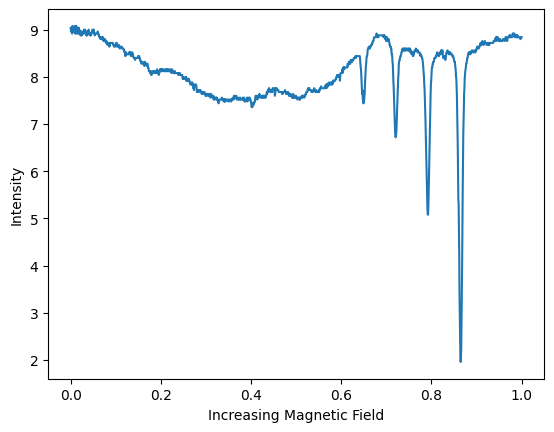

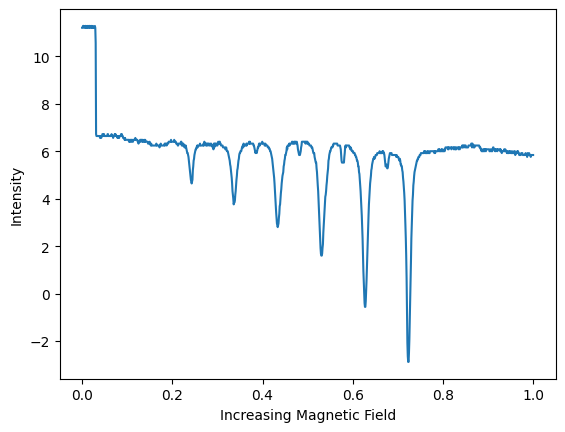

In [171]:
import pandas as pd

sweep1 = pd.read_csv("rb87Sweep.CSV")["PDVoltage"]
sweep1 = sweep1[sweep1> 0.33]
sweep2 = pd.read_csv("rb85Sweep.CSV")["PDVoltage"]
sweep2 = sweep2[sweep2> -5]


plt.plot(np.linspace(0,1,len(sweep1)), sweep1, label='Rb87')
plt.xlabel("Increasing Magnetic Field")
plt.ylabel("Intensity")
plt.show()
plt.plot(np.linspace(0,1,len(sweep2)), sweep2, label='Rb85')
plt.xlabel("Increasing Magnetic Field")
plt.ylabel("Intensity")
plt.show()
